In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [3]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

In [4]:
%run setup_notebooks.py

In [5]:
from src import setup

In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
%matplotlib inline

# A note about interactive visualization

Using the Jupyter magic command `%matplotlib widget` allows to conveniently visualize interactive 3D plots. However, this is quite a mess to install and make work. A few useful remarks:

* You might find this blog [post](https://towardsdatascience.com/make-your-existing-matplotlib-plots-interactive-in-a-single-line-of-python-code-8a6d1673ba2d) useful for installing, especially the two post-installation commands may help:
```shell
jupyter nbextension enable --py --sys-prefix widgetsnbextension
jupyter nbextension install --py --symlink --sys-prefix ipympl
```

* The `%run setup_notebook.py` script might prevent interactive plotting, but not always (?). Probably: it's fine if run the script first then use the `%matplotlib widget` magic.

* **Always use `plt.close()` when finished with interactive plot**, before drawing any other plot

# Visualization Routine

In [8]:
from torch_geometric.utils import k_hop_subgraph

def plot_subgraph(data, k_hop, central_node, directed: bool = False, transparent: bool = False, ax: bool = None, nodesize=50):
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(central_node, k_hop, data.edge_index)
    
    node_xyz = data.coord[sub_nodes, :].numpy()
    edge_xyz = np.array([
        (data.coord[u].numpy(), data.coord[v].numpy()) for u, v in sub_edge_index.T
    ])
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
    
    # Plot edges
    if directed is False:
        alpha = 0.1 if transparent else 0.3
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color='k', alpha=alpha)
    else:
        start_edges = sub_edge_index[1, :]
        
        locX, locY, locZ = data.coord[start_edges].T
        
        end_edges = sub_edge_index[0, :]
        locX2, locY2, locZ2 = data.coord[end_edges].T
        
        dirX, dirY, dirZ = locX2 - locX, locY2 - locY, locZ2 - locZ
        
        alpha = 0.3 if transparent else 0.6
        ax.quiver(locX, locY, locZ, dirX, dirY, dirZ, alpha=alpha)

    # Plot nodes
    color = 'green' if transparent else 'blue'
    ax.scatter3D(*node_xyz.T, s=nodesize, color=color)
    # Plot central node in red
    ax.scatter3D(*node_xyz[central_node].T, color='red', s=2*nodesize)

# Load data

In [9]:
path = setup.get_dataset_path('CoordToCnc')

file = path.joinpath('OLV047_LCX.pt')
assert file.exists()

2022-04-16 13:41:10,230 [setup] [INFO] get_data_path(): using user-defined data path


In [12]:
data = torch.load(file)
data

Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3])

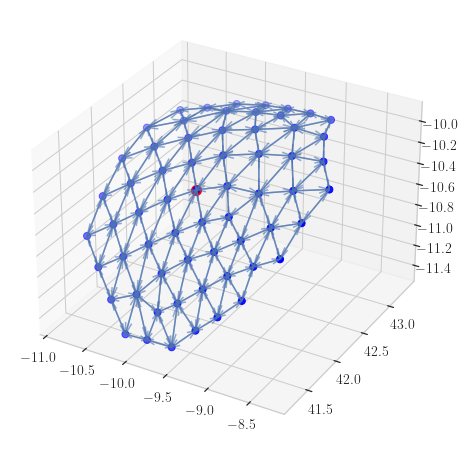

In [12]:
# Sanity check: directions
plot_subgraph(data, k_hop=4, central_node=500, directed=True)

In [173]:
%matplotlib inline

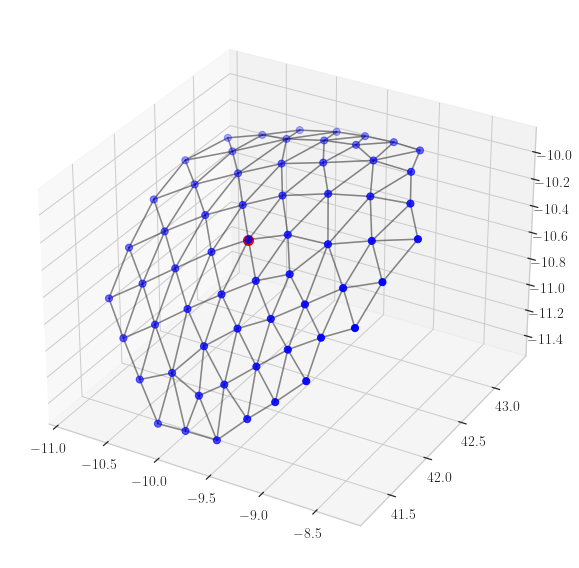

In [175]:
plot_subgraph(data, k_hop=4, central_node=500)
process_figure('figs/viz3d_original.pdf')

# Data augmentation

## KNN

In [11]:
from src.data_augmentation import create_knn_data

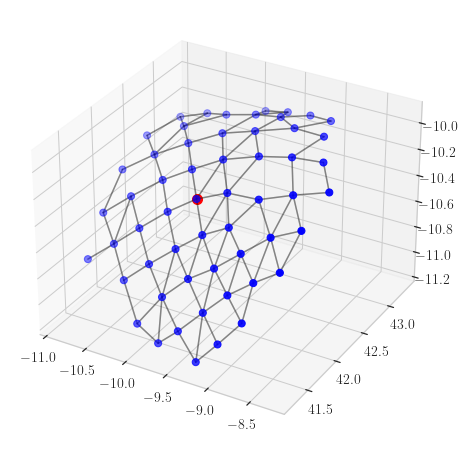

In [21]:
k = 4
knn_edge_index = create_knn_data(data.coord, k_neighbours=k)

data_knn = data.clone()
data_knn.edge_index = knn_edge_index

plot_subgraph(data_knn, k_hop=4, central_node=500)

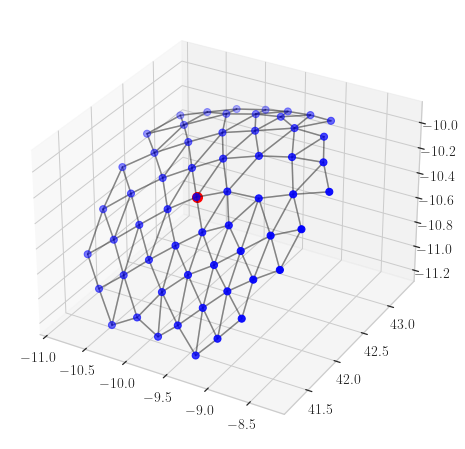

In [19]:
k = 5
knn_edge_index = create_knn_data(data.coord, k_neighbours=k)

data_knn = data.clone()
data_knn.edge_index = knn_edge_index

plot_subgraph(data_knn, k_hop=4, central_node=500)

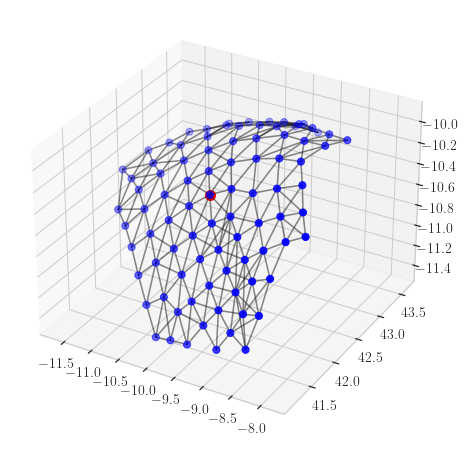

In [20]:
k = 7
knn_edge_index = create_knn_data(data.coord, k_neighbours=k)

data_knn = data.clone()
data_knn.edge_index = knn_edge_index

plot_subgraph(data_knn, k_hop=4, central_node=500)

## Coordinate Gaussian Noise

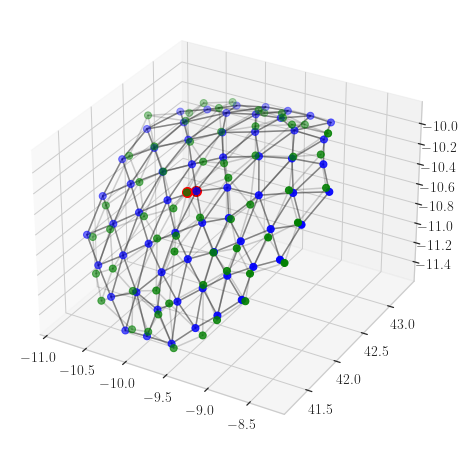

In [187]:
std = 5e-2

data_noise = data.clone()
data_noise.coord += torch.randn_like(data_noise.coord) * std

plot_subgraph(data, k_hop=4, central_node=500)
plot_subgraph(data_noise, k_hop=4, central_node=500, ax=plt.gca(), transparent=True)
#process_figure('figs/viz3d_noise2e-2.pdf')

## Graph diffusion

In [13]:
from data_augmentation import create_diffusion_data

In [14]:
params = (0.05, 0.1, .15, .2)
thres = (1e-3, 5e-3, 1e-2, 5e-2)
diffs = dict()
n = 20
for threshold in thres:
    for param in params:
        diff = create_diffusion_data(data, threshold=threshold, param=param, n=n)
        diffs[(threshold, param)] = diff

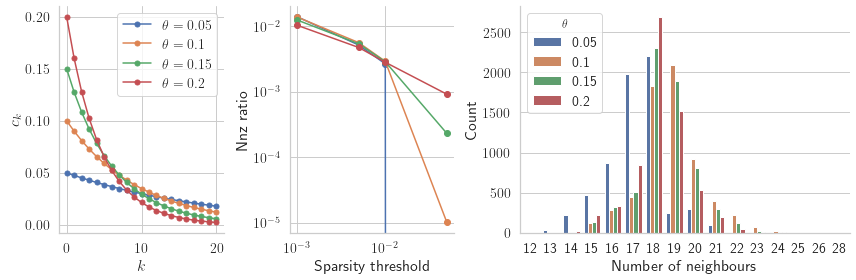

In [18]:
_, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 2]})

k = np.arange(n+1)
for p in params:
    c = p * (1-p)**k
    ax[0].plot(k, c, '-o', label=f'$\\theta = {p}$', markersize=5)


for p in params:
    # Select relevant data
    data_plot = [diffs[(t, p)] for t in thres]
    
    # Compute nnz ratio
    nnz_ratio = [e.edge_index.shape[1] / e.x.shape[0] ** 2 for e in data_plot]
    ax[1].loglog(thres, nnz_ratio, '-o', label=f'$\\theta = {p}$')
    
    
# Compute neighbours hist
dfs = []
threshold = 1e-2
for k, v in diffs.items():
    t, p = k
    if t != threshold: 
        continue
        
    neigh = to_scipy_sparse_matrix(v.edge_index).sum(axis=1)
    neigh = np.array(neigh).squeeze()
    df = pd.DataFrame(neigh.astype(int), columns=['neigh'])
    df['$\\theta$'] = p
    dfs.append(df)
dfs = pd.concat(dfs, ignore_index=True)
sns.countplot(x='neigh', hue='$\\theta$', ax=ax[2], data=dfs, palette='deep')
    
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$c_k$')
ax[1].set_xlabel('Sparsity threshold')
ax[1].set_ylabel('Nnz ratio')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Number of neighbours')
ax[0].legend()
process_figure('figs/diffusion_ppr.pdf')

In [19]:
params = (1, 2, 5, 8)
thres = (1e-3, 5e-3, 1e-2, 5e-2)
diffs = dict()
n=20
for threshold in thres:
    for param in params:
        diff = create_diffusion_data(data, threshold=threshold, param=param, n=n, kernel='heat')
        diffs[(threshold, param)] = diff

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [20]:
from scipy.special import factorial

In [21]:
A = to_scipy_sparse_matrix(data.edge_index)
original_sparsity_ratio = A.nnz / A.shape[0] **2
original_sparsity_ratio

0.0009326356801263674

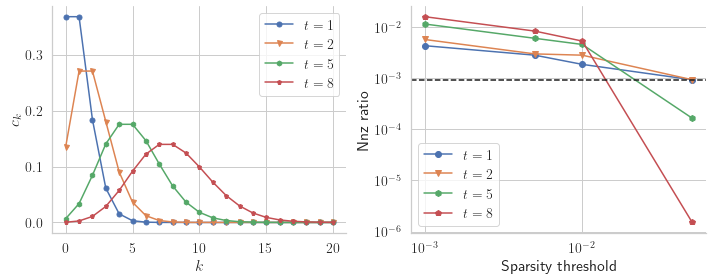

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))#, gridspec_kw={'width_ratios': [1, 1, 1.5]})

ks = np.arange(n+1)
markers = ['o', 'v', 'h', 'p']
for i, t in enumerate(params):
    c = np.exp(-t) * t**ks / factorial(ks)
    ax[0].plot(ks, c, label=f'$t = {t}$', markersize=5, marker=markers[i])


for i, p in enumerate(params):
    # Select relevant data
    data_plot = [diffs[(t, p)] for t in thres]
    
    # Compute nnz ratio
    nnz_ratio = [e.edge_index.shape[1] / e.x.shape[0] ** 2 for e in data_plot]
    ax[1].loglog(thres, nnz_ratio, label=f'$t = {p}$', marker=markers[i])
    
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$c_k$')
ax[1].set_xlabel('Sparsity threshold')
ax[1].set_ylabel('Nnz ratio')
ax[1].axhline(original_sparsity_ratio, ls='--', color='k')
ax[0].legend(); ax[1].legend()
process_figure('figs/diffusion_heat.pdf')

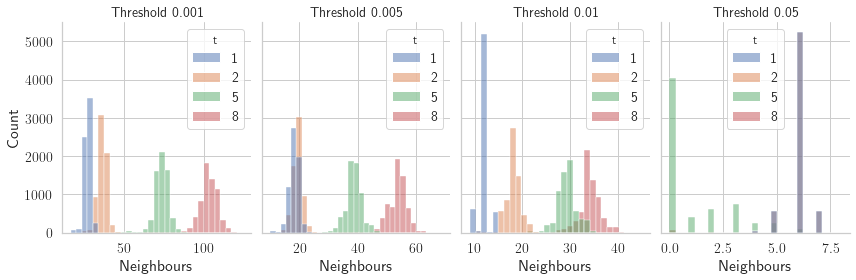

In [23]:
_, ax = plt.subplots(1, len(thres), figsize=(12, 4), sharey=True)

for i, threshold in enumerate(thres):
    # Compute neighbours hist
    dfs = []
    for k, v in diffs.items():
        t, p = k
        if t != threshold: 
            continue

        neigh = to_scipy_sparse_matrix(v.edge_index).sum(axis=1)
        neigh = np.array(neigh).squeeze()
        df = pd.DataFrame(neigh.astype(int), columns=['neigh'])
        df['t'] = p
        dfs.append(df)
    dfs = pd.concat(dfs, ignore_index=True)
    sns.histplot(x='neigh', hue='t', data=dfs, palette='deep', ax=ax[i])
    ax[i].set_xlabel('Neighbours')
    ax[i].set_title(f'Threshold {threshold}')
    
process_figure('figs/diffusion_neighbours.pdf')

In [24]:
diff1 = create_diffusion_data(data, threshold=1e-2, param=1, n=20, kernel='heat')
diff2 = create_diffusion_data(data, threshold=1e-2, param=2, n=20, kernel='heat')

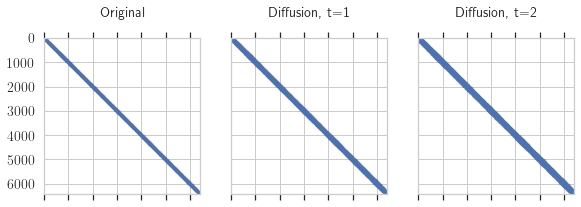

In [56]:
d = [
    (data, 'Original'),
    (diff1, 'Diffusion, t=1'),
    (diff2, 'Diffusion, t=2')
]

_, ax = plt.subplots(1, len(d), sharex=True, sharey=True, figsize=(3*len(d) + .5, 4))
for (dplot, desc), a in zip(d, ax):
    a.spy(to_scipy_sparse_matrix(dplot.edge_index), markersize=0.01)
    a.set_title(desc, y=1.1)
    a.set_xticklabels([])
    #ax.set_xticklabels([]); ax.set_yticklabels([])

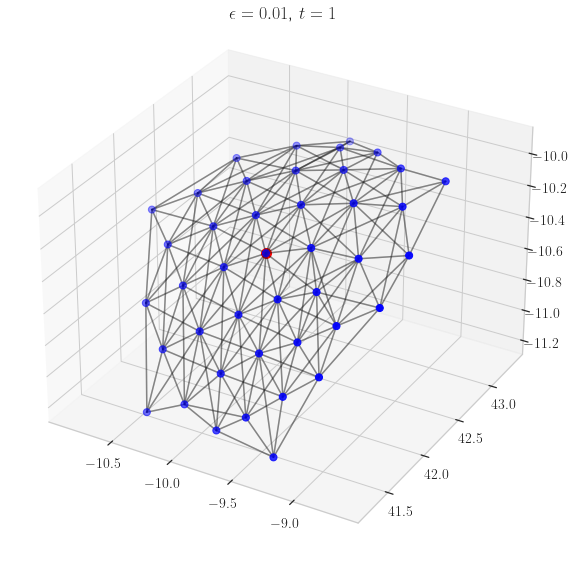

In [25]:
threshold = 1e-2
t = 1
diff = create_diffusion_data(data, threshold=threshold, param=t, n=20, kernel='heat')

plot_subgraph(diff, k_hop=2, central_node=500)
plt.title(f'$\epsilon={threshold}$, $t={t}$', fontsize=18, y=1.05)
process_figure(f'figs/diffusion_graph_heat_thres{threshold}_t{t}.pdf')

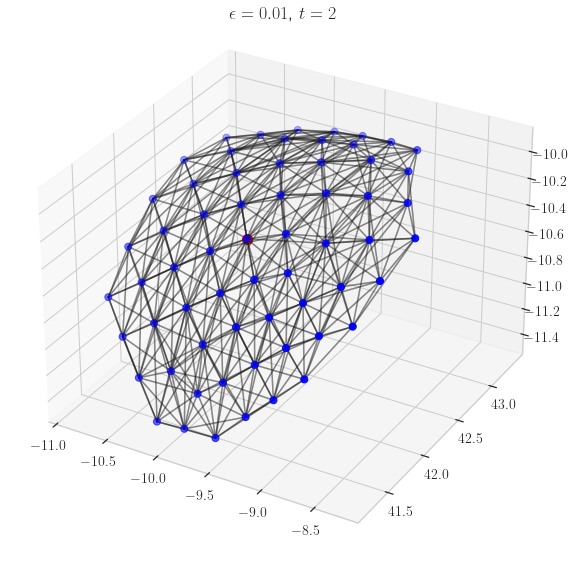

In [381]:
threshold = 1e-2
t = 2
diff = create_diffusion_data(data, threshold=threshold, param=t, n=20, kernel='heat')

plot_subgraph(diff, k_hop=2, central_node=500)
plt.title(f'$\epsilon={threshold}$, $t={t}$', fontsize=18, y=1.05)
process_figure(f'figs/diffusion_graph_heat_thres{threshold}_t{t}.pdf')

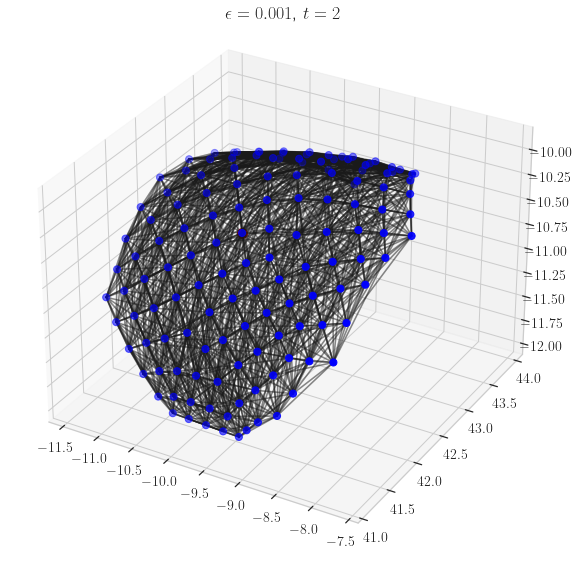

In [382]:
threshold = 1e-3
t = 2
diff = create_diffusion_data(data, threshold=threshold, param=t, n=20, kernel='heat')

plot_subgraph(diff, k_hop=2, central_node=500)
plt.title(f'$\epsilon={threshold}$, $t={t}$', fontsize=18, y=1.05)
process_figure(f'figs/diffusion_graph_heat_thres{threshold}_t{t}.pdf')

## Randomized diffusion

In [390]:
diff = create_diffusion_data(data, threshold=5e-4, param=8, n=20, kernel='heat')

In [391]:
A = to_scipy_sparse_matrix(diff.edge_index)
nnz_r, nnz_c = A.nonzero()

In [392]:
def get_neigh(i, nnz_r, nnz_c):
    mask = nnz_r == i
    return nnz_c[mask]

In [393]:
n_connections = 3
new_connections = []
for i in range(A.shape[0]):
    neigh = get_neigh(i, nnz_r, nnz_c)
    w = np.array(diff.edge_weight[neigh])
    w /= w.sum()
    chosen = np.random.choice(neigh, size=n_connections, p=w, replace=False)
    new_connections.extend([
        (i, u) for u in chosen
    ])

In [394]:
new_edges = torch.tensor(new_connections)
new_edges = torch.concat((new_edges, new_edges[:, [1, 0]])).T

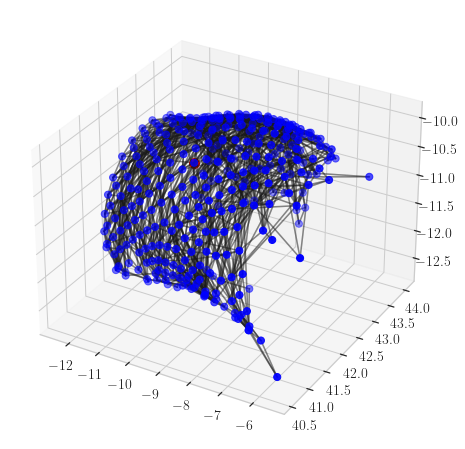

In [396]:
plot_subgraph(sample_rd, k_hop=3, central_node=500)

## Long range connections

In [394]:
def long_range_connections(A, offsets):
    if isinstance(offsets, int):
        offsets = [offsets]
        
    n = A.shape[0]
    ds = [
        np.ones(n - offset) for offset in offsets
    ]
    D = scipy.sparse.diags(ds, offsets)
    D = D + D.T
    return A + D

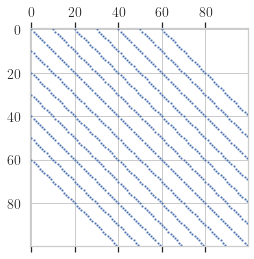

In [429]:
I = scipy.sparse.eye(100)
I = long_range_connections(I, 10)
I = I ** 6
plt.spy(I, markersize=1)

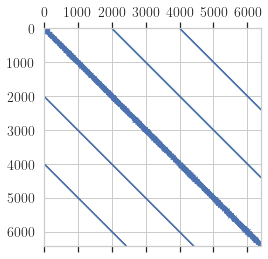

In [414]:
M = long_range_connections(to_scipy_sparse_matrix(data.edge_index), [2000, 4000])
#plt.imshow(M.todense(), cmap='binary', alpha=1)
plt.spy(M, markersize=0.1)

In [421]:
data_range = data.clone()
data_range.edge_index, _ = from_scipy_sparse_matrix(M)
data_range

Data(x=[6416, 0], edge_index=[2, 52056], y=1, coord=[6416, 3], g_x=[1, 3])

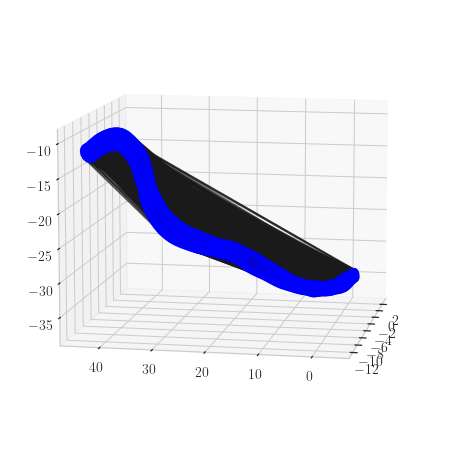

In [422]:
plot_subgraph(data_range, k_hop=200, central_node=3000, nodesize=5)
plt.gca().view_init(9.897682873478175, -169.19232451839676)

In [186]:
from scipy.spatial import distance_matrix
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy

In [180]:
A = to_scipy_sparse_matrix(data.edge_index)

k = 10
Akm1 = A **(k-1)
Ak = A @ Akm1

Ak.data = np.ones_like(Ak.data)

In [215]:
tmp1 = Ak.copy()
tmp1.data = np.ones_like(tmp1.data)
tmp2 = Akm1.copy()
tmp2.data = np.ones_like(tmp2.data)

M = tmp1 - tmp2

In [231]:
def get_khop_nodes(i, Ak_nnz_r, Ak_nnz_c):
    mask = Ak_nnz_r == i
    target_nodes = Ak_nnz_c[mask]
    return target_nodes

In [252]:
from scipy.special import softmax

In [233]:
get_khop_nodes(0, *M.nonzero())

array([ 15,  17,  86, 326, 280, 267, 191, 110, 476, 421, 380, 348, 365,
       552, 504, 573, 563, 542, 498, 474, 601, 590, 559, 592, 540, 519,
       525, 503,  26,  28, 111, 233, 178, 473, 432, 376, 304, 278, 508],
      dtype=int32)

In [340]:
# Distances of target nodes w.r.t. final node
nnz_r, nnz_c = M.nonzero()

i = 1000
target_nodes = get_khop_nodes(i, nnz_r, nnz_c)
d = D[end, target_nodes]

tmp = np.argsort(d)
sorted_target = target_nodes[tmp]
sorted_d = d[tmp]

probas = softmax(-sorted_d)
next_node = np.random.choice(sorted_target, p=probas)

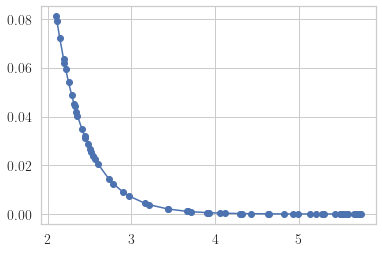

In [342]:
a = (sorted_d - sorted_d.min()) / (sorted_d.max() - sorted_d.min())
p = softmax(-10*a)

plt.plot(sorted_d, p, '-o')

In [299]:
def choose_next_node(sorted_d, sorted_nodes):
    a = (sorted_d - sorted_d.min()) / (sorted_d.max() - sorted_d.min())
    p = softmax(-10 * a)
    choice = np.random.choice(sorted_nodes, p=p)
    return choice

In [337]:
choose_next_node(sorted_d, sorted_target)

396

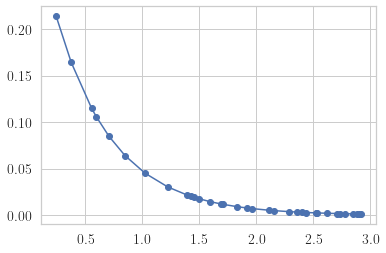

In [279]:
plt.plot(sorted_d, softmax(-sorted_d*2), '-o')

In [257]:
softmax(-sorted_d)

array([0.06984848, 0.06951671, 0.06628238, 0.06283496, 0.06181198,
       0.06017619, 0.05963175, 0.05841822, 0.0545205 , 0.04746762,
       0.04531903, 0.04070619, 0.03992887, 0.03469818, 0.03171579,
       0.02859032, 0.02310315, 0.02144982, 0.01379921, 0.01020778,
       0.00778913, 0.00700811, 0.00690696, 0.00588772, 0.00581183,
       0.00553227, 0.00548199, 0.00516395, 0.0050755 , 0.00486501,
       0.0046483 , 0.00460303, 0.00453491, 0.00450989, 0.00450866,
       0.00447377, 0.00447214, 0.00435075, 0.00434896])

In [248]:
t = 1/sorted_d
t /= t.sum()
t

array([0.02642057, 0.02641808, 0.02639309, 0.02636514, 0.02635656,
       0.02634256, 0.02633781, 0.02632709, 0.02629115, 0.02621933,
       0.0261954 , 0.02614012, 0.02613022, 0.02605831, 0.0260125 ,
       0.02595981, 0.02585225, 0.02581498, 0.02559578, 0.0254481 ,
       0.02531707, 0.02526624, 0.02525927, 0.02518288, 0.0251767 ,
       0.02515322, 0.02514888, 0.02512048, 0.02511228, 0.02509221,
       0.02507065, 0.02506603, 0.02505898, 0.02505637, 0.02505624,
       0.02505257, 0.0250524 , 0.02503942, 0.02503923])

In [251]:
np.diff(sorted_d)

array([4.76110848e-03, 4.76431196e-02, 5.34124210e-02, 1.64143696e-02,
       2.68205412e-02, 9.08860204e-03, 2.05603575e-02, 6.90509437e-02,
       1.38529019e-01, 4.63206646e-02, 1.07347035e-01, 1.92805484e-02,
       1.40412254e-01, 8.98726233e-02, 1.03746483e-01, 2.13099159e-01,
       7.42527080e-02, 4.41105248e-01, 3.01461364e-01, 2.70419993e-01,
       1.05661451e-01, 1.45385378e-02, 1.59661261e-01, 1.29723327e-02,
       4.92984352e-02, 9.12938821e-03, 5.97669298e-02, 1.72768444e-02,
       4.23551045e-02, 4.55678946e-02, 9.78743648e-03, 1.49086865e-02,
       5.53174814e-03, 2.72891611e-04, 7.77002742e-03, 3.64032639e-04,
       2.75173853e-02, 4.12600435e-04])

In [244]:
sorted_d, sorted_target

(array([50.32669768, 50.33145879, 50.37910191, 50.43251433, 50.4489287 ,
        50.47574924, 50.48483784, 50.5053982 , 50.57444914, 50.71297816,
        50.75929883, 50.86664586, 50.88592641, 51.02633866, 51.11621129,
        51.21995777, 51.43305693, 51.50730964, 51.94841488, 52.24987625,
        52.52029624, 52.62595769, 52.64049623, 52.80015749, 52.81312982,
        52.86242826, 52.87155765, 52.93132458, 52.94860142, 52.99095652,
        53.03652442, 53.04631186, 53.06122054, 53.06675229, 53.06702518,
        53.07479521, 53.07515924, 53.10267663, 53.10308923]),
 array([503, 508, 473, 525, 432, 592, 376, 601, 304, 278, 590, 178, 233,
        111, 559,  28,  26, 540, 519, 542, 563, 267, 191, 573, 280, 498,
        110, 326,  17, 474, 365, 380,  15, 421, 476, 504, 552, 348,  86],
       dtype=int32))

In [234]:
start = 0
end = np.argmax(D[start, :])
i = start
while True:
    #dist_from_current = D[]
    break

In [464]:
%%timeit
#nnz_r, nnz_c = Ak.nonzero()

mask = nnz_r == i

761 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [462]:
nnz_r[mask], nnz_c[mask]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int32),
 array([508, 503, 473, 432, 456, 418, 376, 393, 307, 304, 278, 233, 247,
        169, 190, 119,  34, 124, 279, 256, 213, 206, 170, 168, 137,  91,
        178, 144,  31, 111,  27,  30,  32,  90,  29,  28,  26,  33,  36,
        138, 573, 563, 498, 474, 504, 552, 476, 421, 380, 348, 326, 365,
       

In [452]:
mask.sum()

216

In [ ]:
np.argwhere()

## Trimesh

In [46]:
from torch_geometric.utils import to_trimesh as torch_to_trimesh

In [47]:
def to_trimesh(data):
    data = data.clone()
    data.pos = data.coord
    T = torch_to_trimesh(data)
    return T

## PyGSP Package - Reduction 

This library is just not efficient at all, real computations raise out of memory errors.

In [31]:
import pygsp
from pygsp import reduction

In [32]:
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix, from_scipy_sparse_matrix

def to_pygsp_graph(data: Data):
    A = to_scipy_sparse_matrix(data.edge_index)
    G = pygsp.graphs.Graph(A, coords=data.coord)
    return G

def pygsp_to_data(G: pygsp.graphs.graph.Graph):
    edge_index, edge_weight = from_scipy_sparse_matrix(G.A)
    data = Data(edge_index=edge_index, coord=torch.from_numpy(G.coords))
    return data

In [33]:
from torch_geometric.utils import k_hop_subgraph

def khop_data(data: Data, k_hop: int, central_node: int):
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(central_node, k_hop, data.edge_index, relabel_nodes=True)
    
    out = data.clone()
    out.edge_index = sub_edge_index
    out.coord = data.coord[sub_nodes]
    out.x = data.x[sub_nodes]
    
    return out

In [41]:
G = to_pygsp_graph(data)

## Graph coarsening (built on top of PyGSP)

https://github.com/loukasa/graph-coarsening

In [42]:
G = to_pygsp_graph(data)

In [26]:
%matplotlib widget

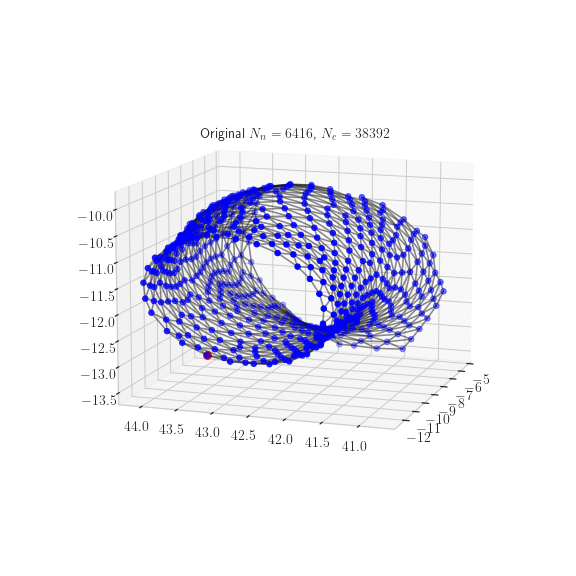

In [153]:
viewangles = (-161.2442927070052, 11.77008350129529)

plot_subgraph(data, k_hop=20, central_node=0, nodesize=30)

N, Ne = data.coord.shape[0], data.edge_index.shape[1]

ax = plt.gca()
ax.view_init(viewangles[1], viewangles[0])
plt.title(f'Original $N_n={N}$, $N_e = {Ne}$', y=.9)
plt.savefig(f'figs/viz3d_coarsening_original.pdf')

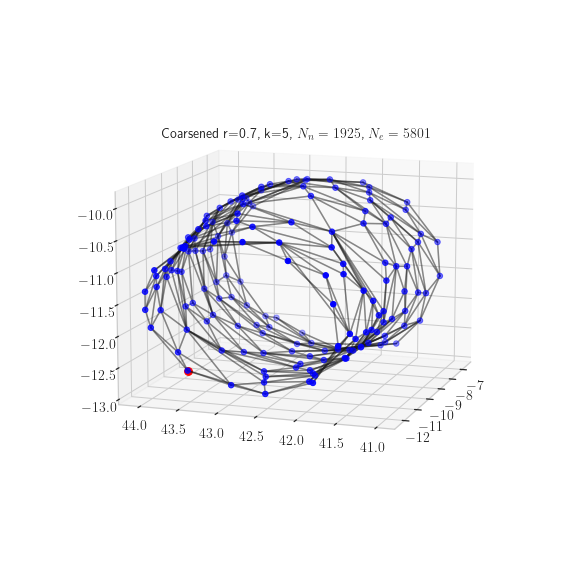

In [160]:
from graph_coarsening.coarsening_utils import coarsen

method = 'variation_neighborhood'

r = 0.7
k = 5
kmax = 3*k

_, Gc, *_ = coarsen(G, K=k, r=r, method=method)


viewangles = (-161.2442927070052, 11.77008350129529)

plot_subgraph(pygsp_to_data(Gc), k_hop=10, central_node=0, nodesize=30)

ax = plt.gca()
ax.view_init(viewangles[1], viewangles[0])
plt.title(f'Coarsened r={r}, k={k}, $N_n={Gc.N}$, $N_e = {Gc.Ne}$', y=.9)
plt.savefig(f'figs/viz3d_coarsening_r{r}_k{k}.pdf')

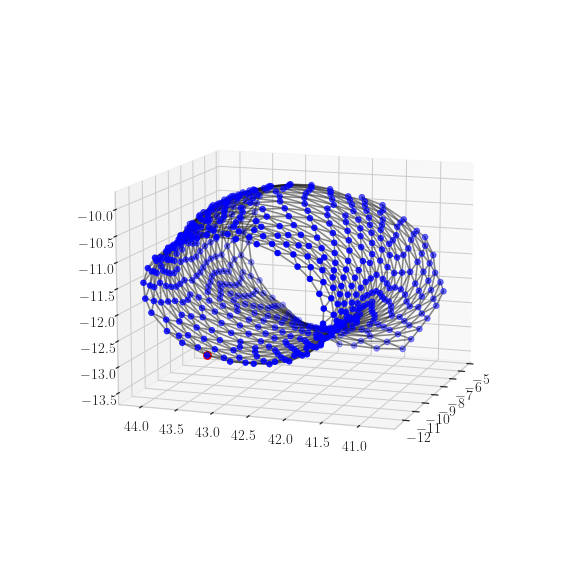

In [127]:
plt.savefig('figs/viz3d_coarsening_original.pdf')

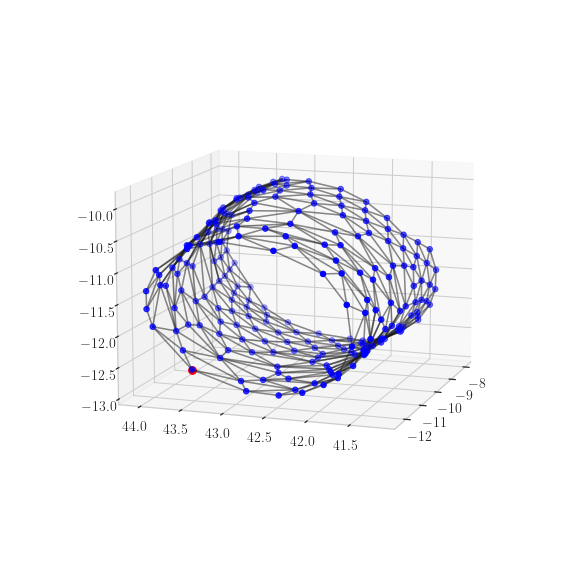

In [123]:
viewangles = (-161.2442927070052, 11.77008350129529)

plot_subgraph(pygsp_to_data(Gc), k_hop=10, central_node=0, nodesize=30)

ax = plt.gca()
ax.view_init(viewangles[1], viewangles[0])

In [105]:
a = plt.gca()
a.azim, a.elev

(-161.2442927070052, 11.77008350129529)

In [106]:
process_figure('figs/viz_3d_coarsened_r0.7_full.pdf')

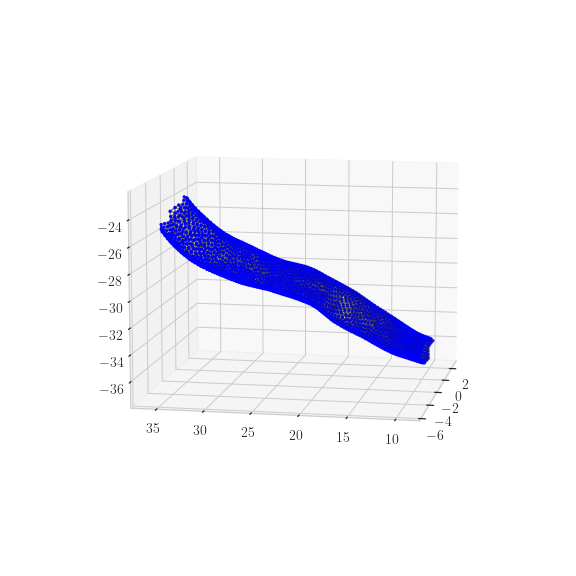

In [171]:
plot_subgraph(data, k_hop=200, central_node=3000, nodesize=5)
plt.gca().view_init(9.897682873478175, -169.19232451839676)

In [168]:
process_figure('figs/viz3d_full_original.pdf')

In [155]:
plt.gca().elev, plt.gca().azim

(9.897682873478175, -169.19232451839676)

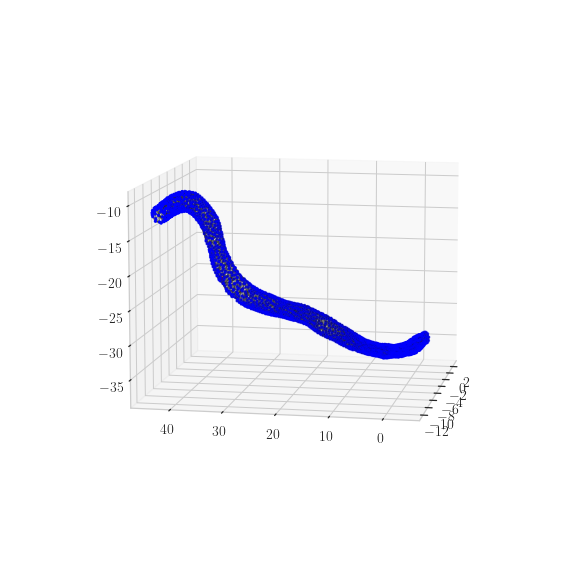

In [164]:
plot_subgraph(pygsp_to_data(Gc), k_hop=200, central_node=1000, nodesize=5)
plt.gca().view_init(9.897682873478175, -169.19232451839676)

In [183]:
data_test = torch.load('../data/sample_coarse.pt')
data_test

Data(x=[2031, 0], edge_index=[2, 12224], y=0, coord=[2031, 3], g_x=[1, 3])

In [184]:
data_test.edge_index.max()

tensor(2030)